In [5]:
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import StratifiedGroupKFold
from pandarallel import pandarallel
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from matchms import Spectrum
from matchms.exporting import save_as_mgf
import massspecgym.utils as utils

In [11]:
df = pd.read_csv('../../data/data/MassSpecGym.tsv', sep='\t')
df

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_4583/2974025736.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/data/MassSpecGym.tsv', sep='\t')


,mzs,intensities,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,collision_energy,identifier,smiles
0,"91.0542,125.0233,154.0499,155.0577,185.0961,20...","0.24524524524524524,1.0,0.08008008008008008,0....",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"30.0 (normalized=False, ramped=False)",MassSpecGymID0000001,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
1,"91.0542,125.0233,155.0577,185.0961,229.0859,24...","0.0990990990990991,0.28128128128128127,0.04004...",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"20.0 (normalized=False, ramped=False)",MassSpecGymID0000002,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
2,"69.0343,91.0542,125.0233,127.039,153.0699,154....","0.03403403403403404,0.31431431431431434,1.0,0....",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"40.0 (normalized=False, ramped=False)",MassSpecGymID0000003,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
3,"69.0343,91.0542,110.06,111.0441,112.0393,120.0...","0.17917917917917917,0.47347347347347346,0.0380...",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"55.0 (normalized=False, ramped=False)",MassSpecGymID0000004,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
4,"91.0542,125.0233,185.0961,229.0859,246.1125,28...","0.07807807807807808,0.1841841841841842,0.03503...",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"10.0 (normalized=False, ramped=False)",MassSpecGymID0000005,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
233441,"77.5606,85.238739,152.079361,156.231537,189.96...","0.00022242662384734551,0.0007871876908597226,0...",InChI=1S/C56H98N16O13/c1-7-32(4)13-11-12-16-44...,WQVJHHACXVLGBL,1225.7400,[M+Na]+,1202.750782,C56H98N16O13,C56H98N16NaO13,QTOF,NaN,MassSpecGymID0414170,CCC(C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([C@@H]...
233442,"72.043739,86.060242,98.058304,99.0634,126.0537...","0.0019527744563354998,0.0016939927337585416,0....",InChI=1S/C22H23ClN2O8/c1-21(32)7-6-8-15(25(2)3...,DHPRQBPJLMKORJ,479.1230,[M+H]+,478.115724,C22H23ClN2O8,C22H24ClN2O8,QTOF,NaN,MassSpecGymID0414171,C[C@@]1([C@H]2C[C@H]3[C@@H](C(=O)C(=C([C@]3(C(...
233443,"72.080132,102.233917,113.082344,113.121498,114...","0.021173783463613503,0.007516001055215398,0.03...",InChI=1S/C21H43N5O7/c1-9(25-3)13-6-5-10(22)19(...,CEAZRRDELHUEMR,478.3250,[M+H]+,477.317724,C21H43N5O7,C21H44N5O7,QTOF,NaN,MassSpecGymID0414172,C[C@H]([C@@H]1CC[C@H]([C@H](O1)O[C@@H]2[C@H](C...
233444,"55.053627,56.455425,58.065819,67.053543,82.065...","0.031731527156456024,0.017878400151027027,0.07...",InChI=1S/C21H43N5O7/c1-9(25-3)13-6-5-10(22)19(...,CEAZRRDELHUEMR,478.3250,[M+H]+,477.317724,C21H43N5O7,C21H44N5O7,QTOF,NaN,MassSpecGymID0414173,C[C@H]([C@@H]1CC[C@H]([C@H](O1)O[C@@H]2[C@H](C...


### Prepare SMILES and pre-computed MCES distances

In [12]:
f = h5py.File('../../data/all_smiles_standardized_mces/all_smiles_mces.hdf5', 'r')
print(list(f.keys()))
dists = squareform(f['mces'])
dists_smiles = f['mces_smiles_order'][:].astype(str).tolist()
dists.shape, len(dists_smiles)

['mces', 'mces_smiles_order']


((34731, 34731), 34731)

In [13]:
for s in df['smiles'].unique():
    assert s in dists_smiles

In [15]:
unique_smiles = df['smiles'].unique()
smiles_mask = np.array([s in unique_smiles for s in dists_smiles])
print(smiles_mask.shape[0], smiles_mask.sum(), len(unique_smiles))

dists = dists[smiles_mask, :][:, smiles_mask]
dists_smiles = np.array(dists_smiles)[smiles_mask]

from scipy.linalg import issymmetric
assert issymmetric(dists)

len(dists_smiles), dists.shape

32010 32010 32010


(32010, (32010, 32010))

### Perform agglomerative clustering using MCES distances

In [16]:
clustering = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    distance_threshold=10,
    n_clusters=None
).fit(dists)
clusters = clustering.labels_
pd.Series(clusters).value_counts()

19      20472
476        90
411        90
468        73
1894       71
        ...  
4884        1
4885        1
4587        1
4886        1
4452        1
Name: count, Length: 7642, dtype: int64

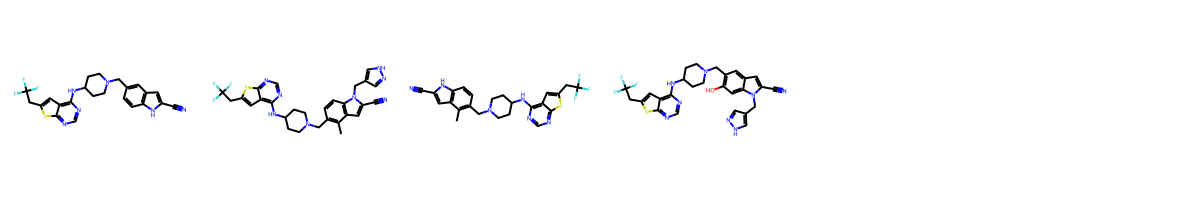

In [21]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in dists_smiles[np.where(clusters == 2)[0]]], molsPerRow=6, subImgSize=(200, 200))

### Define train-validation-test split

Compute metadata stratification groups

In [22]:
smiles_to_cluster = dict(zip(dists_smiles, clusters))
df['cluster'] = df['smiles'].map(smiles_to_cluster)

top_k_ces = df['collision_energy'].value_counts().index[:5]
smiles_vc = df['smiles'].value_counts()

def simple_ce(ce):
    if pd.isnull(ce):
        return 'none'
    if ce in top_k_ces:
        return ce
    return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c < 3:
        return '(0, 3)'
    elif c <= 5:
        return '(3, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def stratification_group(row):
    return str(row['adduct']) + \
        str(row['instrument_type']) + \
        str(simple_ce(row['collision_energy'])) + \
        str(simple_smiles_count(row['smiles']))
df['stratification_group'] = df.apply(stratification_group, axis=1)
df['stratification_group'].value_counts()

stratification_group
[M+H]+ITFTnone(5, 100]                                   38057
[M+Na]+ITFTnone(5, 100]                                  21861
[M+H]+QTOFother(5, 100]                                  17644
[M+H]+ITFTother(5, 100]                                  16233
[M+H]+QFTother(5, 100]                                   12553
                                                         ...  
[M+Na]+QFT20.0 (normalized=False, ramped=False)(0, 3)        1
[M+Na]+nannone(100, inf)                                     1
[M+H]+nan30.0 (normalized=False, ramped=False)(0, 3)         1
[M+H]+QTOF45.0 (normalized=False, ramped=False)(0, 3)        1
[M+Na]+Orbitrapother(0, 3)                                   1
Name: count, Length: 169, dtype: int64

Split with `StratifiedGroupKFold`

In [23]:
X = df['identifier'].values
y = df['stratification_group'].values
groups = df['cluster'].values
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)
folds = []
for i, (train_index, test_index) in enumerate(sgkf_split):
    print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
    folds.append(X[test_index])

/Users/roman/miniconda/envs/massspecgym/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


170111 (72.87 %)
31568 (13.52 %)
31767 (13.61 %)


In [24]:
folds_map = {}
for i, fold in enumerate(folds):
    for identifier in fold:
        folds_map[identifier] = ['train', 'val', 'test'][i]
df['fold'] = df['identifier'].map(folds_map)

def fold_composition(df_q, percentage=True):
    unique_counts = df_q.groupby(['fold']).agg({'smiles': 'nunique', 'identifier': 'nunique', 'cluster': 'nunique'})
    if not percentage:
        return unique_counts
    total_counts = df_q.agg({'smiles': 'nunique', 'identifier': 'nunique', 'cluster': 'nunique'})
    percentage_counts = (unique_counts / total_counts) * 100
    percentage_counts = percentage_counts.round(2)
    return percentage_counts
for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df.dropna(), percentage=percentage))

Full dataset (percentage=False)


,smiles,identifier,cluster
fold,,,
test,5720,31767,3766
train,20540,170111,69
val,5750,31568,3807


All metadata available (percentage=False)


,smiles,identifier,cluster
fold,,,
test,4173,17205,3220
train,10206,87898,69
val,4194,17201,3239


Full dataset (percentage=True)


,smiles,identifier,cluster
fold,,,
test,17.87,13.61,49.28
train,64.17,72.87,0.90
val,17.96,13.52,49.82


All metadata available (percentage=True)


,smiles,identifier,cluster
fold,,,
test,22.47,14.07,49.33
train,54.95,71.87,1.06
val,22.58,14.06,49.62


### Additionally move random validation and test clusters to the train fold

In [25]:
df_split = df.copy()
for f in ['val', 'test']:
    df_fold = df[df['fold'] == f].copy()
    rand_fold_clusters = df_fold['cluster'].drop_duplicates().sample(n=1500, random_state=42).values
    df_split.loc[df_split['cluster'].isin(rand_fold_clusters), 'fold'] = 'train'

for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df_split, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df_split.dropna(), percentage=percentage))

Full dataset (percentage=False)


,smiles,identifier,cluster
fold,,,
test,3356,17382,2266
train,25320,197792,3069
val,3334,18272,2307


All metadata available (percentage=False)


,smiles,identifier,cluster
fold,,,
test,2532,9930,1937
train,13583,102433,2630
val,2458,9941,1961


Full dataset (percentage=True)


,smiles,identifier,cluster
fold,,,
test,10.48,7.45,29.65
train,79.10,84.73,40.16
val,10.42,7.83,30.19


All metadata available (percentage=True)


,smiles,identifier,cluster
fold,,,
test,13.63,8.12,29.67
train,73.13,83.75,40.29
val,13.23,8.13,30.04


------------------------------ Full dataset ------------------------------


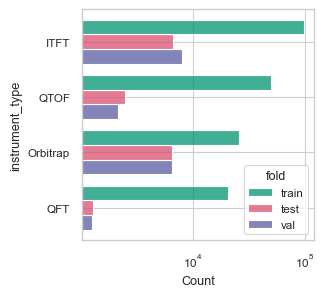

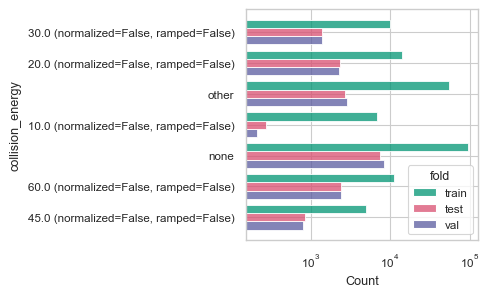

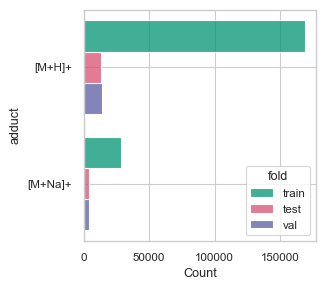

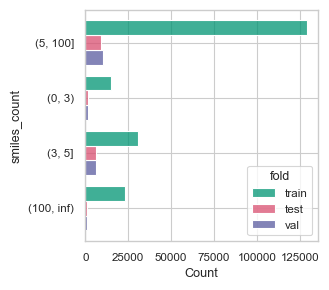

------------------------------ All metadata available ------------------------------


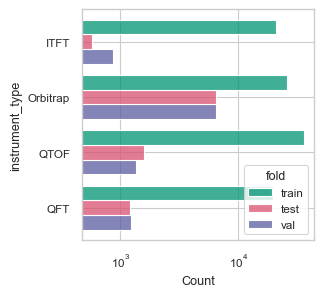

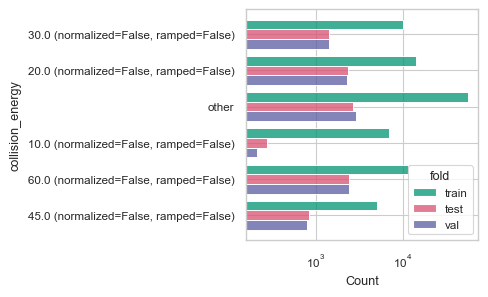

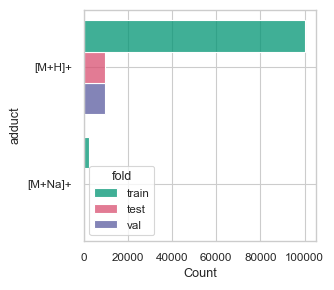

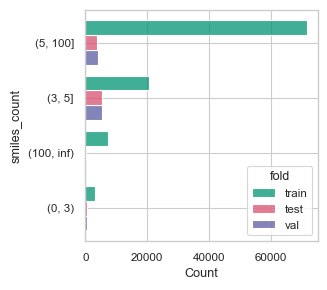

In [26]:
utils.init_plotting(figsize=(3, 3))

for df_name, df_plot in [('Full dataset', df_split.copy()), ('All metadata available', df_split.copy().dropna())]:
    print('-' * 30, df_name, '-' * 30)
    df_plot['instrument_type'] = df_plot['instrument_type'].str.replace('Q Exactive Focus Hybrid Quadrupole Orbitrap Mass Spectrometer (Thermo Fisher Scientific)', 'Q Exactive')
    df_plot['collision_energy'] = df_plot['collision_energy'].apply(simple_ce)
    df_plot['smiles_count'] = df_plot['smiles'].apply(simple_smiles_count)

    sns.histplot(y='instrument_type', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    plt.xscale('log')
    plt.show()

    sns.histplot(y='collision_energy', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    plt.xscale('log')
    plt.show()

    sns.histplot(y='adduct', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    # plt.xscale('log')
    plt.show()

    sns.histplot(y='smiles_count', data=df_plot, hue='fold', multiple='dodge', discrete=True, shrink=.8)
    plt.show()

In [27]:
fps = {}
for fold in ['train', 'val', 'test']:
    df_fold = df_split[df_split['fold'] == fold]
    df_fold = df_fold.drop_duplicates(subset='smiles')
    fps[fold] = df_fold['smiles'].progress_apply(lambda s: utils.morgan_fp(Chem.MolFromSmiles(s), to_np=False))
def max_train_tanimoto(test_fp, train_fps=fps['train']):
    return max([DataStructs.FingerprintSimilarity(test_fp, train_fp) for train_fp in train_fps])

100%|██████████| 3356/3356 [00:00<00:00, 5058.70it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


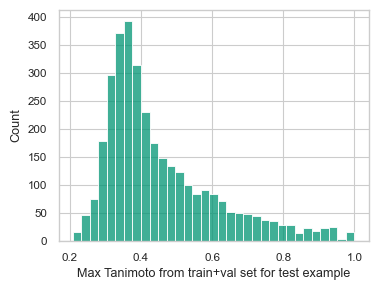

In [28]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['test'].parallel_apply(lambda f: max_train_tanimoto(f, pd.concat([fps['train'], fps['val']])))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train+val set for test example')
plt.show()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


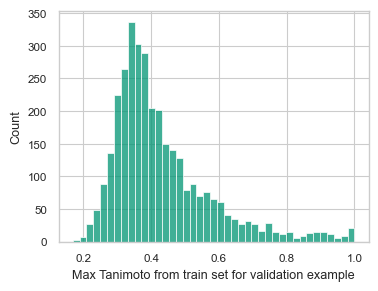

In [29]:
pandarallel.initialize(nb_workers=8, progress_bar=True)
max_train_tanimotos = fps['val'].parallel_apply(lambda f: max_train_tanimoto(f, fps['train']))
utils.init_plotting(figsize=(4, 3))
sns.histplot(max_train_tanimotos)
plt.xlabel('Max Tanimoto from train set for validation example')
plt.show()

In [30]:
df

,mzs,intensities,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,collision_energy,identifier,smiles,cluster,stratification_group,fold
0,"91.0542,125.0233,154.0499,155.0577,185.0961,20...","0.24524524524524524,1.0,0.08008008008008008,0....",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"30.0 (normalized=False, ramped=False)",MassSpecGymID0000001,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,19,"[M+H]+ITFT30.0 (normalized=False, ramped=False...",train
1,"91.0542,125.0233,155.0577,185.0961,229.0859,24...","0.0990990990990991,0.28128128128128127,0.04004...",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"20.0 (normalized=False, ramped=False)",MassSpecGymID0000002,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,19,"[M+H]+ITFT20.0 (normalized=False, ramped=False...",train
2,"69.0343,91.0542,125.0233,127.039,153.0699,154....","0.03403403403403404,0.31431431431431434,1.0,0....",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"40.0 (normalized=False, ramped=False)",MassSpecGymID0000003,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,19,"[M+H]+ITFTother(5, 100]",train
3,"69.0343,91.0542,110.06,111.0441,112.0393,120.0...","0.17917917917917917,0.47347347347347346,0.0380...",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"55.0 (normalized=False, ramped=False)",MassSpecGymID0000004,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,19,"[M+H]+ITFTother(5, 100]",train
4,"91.0542,125.0233,185.0961,229.0859,246.1125,28...","0.07807807807807808,0.1841841841841842,0.03503...",InChI=1S/C16H17NO4/c1-11(18)17-14(8-12-6-4-3-5...,VFMQMACUYWGDOJ,288.1225,[M+H]+,287.115224,C16H17NO4,C16H18NO4,ITFT,"10.0 (normalized=False, ramped=False)",MassSpecGymID0000005,CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,19,"[M+H]+ITFT10.0 (normalized=False, ramped=False...",train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233441,"77.5606,85.238739,152.079361,156.231537,189.96...","0.00022242662384734551,0.0007871876908597226,0...",InChI=1S/C56H98N16O13/c1-7-32(4)13-11-12-16-44...,WQVJHHACXVLGBL,1225.7400,[M+Na]+,1202.750782,C56H98N16O13,C56H98N16NaO13,QTOF,NaN,MassSpecGymID0414170,CCC(C)CCCCC(=O)N[C@@H](CCN)C(=O)N[C@@H]([C@@H]...,2402,"[M+Na]+QTOFnone(0, 3)",test
233442,"72.043739,86.060242,98.058304,99.0634,126.0537...","0.0019527744563354998,0.0016939927337585416,0....",InChI=1S/C22H23ClN2O8/c1-21(32)7-6-8-15(25(2)3...,DHPRQBPJLMKORJ,479.1230,[M+H]+,478.115724,C22H23ClN2O8,C22H24ClN2O8,QTOF,NaN,MassSpecGymID0414171,C[C@@]1([C@H]2C[C@H]3[C@@H](C(=O)C(=C([C@]3(C(...,334,"[M+H]+QTOFnone(0, 3)",test
233443,"72.080132,102.233917,113.082344,113.121498,114...","0.021173783463613503,0.007516001055215398,0.03...",InChI=1S/C21H43N5O7/c1-9(25-3)13-6-5-10(22)19(...,CEAZRRDELHUEMR,478.3250,[M+H]+,477.317724,C21H43N5O7,C21H44N5O7,QTOF,NaN,MassSpecGymID0414172,C[C@H]([C@@H]1CC[C@H]([C@H](O1)O[C@@H]2[C@H](C...,148,"[M+H]+QTOFnone(3, 5]",test
233444,"55.053627,56.455425,58.065819,67.053543,82.065...","0.031731527156456024,0.017878400151027027,0.07...",InChI=1S/C21H43N5O7/c1-9(25-3)13-6-5-10(22)19(...,CEAZRRDELHUEMR,478.3250,[M+H]+,477.317724,C21H43N5O7,C21H44N5O7,QTOF,NaN,MassSpecGymID0414173,C[C@H]([C@@H]1CC[C@H]([C@H](O1)O[C@@H]2[C@H](C...,148,"[M+H]+QTOFnone(3, 5]",test


In [32]:
df = df_split.drop(columns=['cluster', 'stratification_group'])
df['simulation_challenge'] = (~df.isna().sum(axis=1)) & (df['adduct'] == '[M+H]+')
df.to_csv('../../data/data/MassSpecGym.tsv', sep='\t', index=False)

### Convert final dataset to `.mgf`

In [37]:
spectra = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    spec = Spectrum(
        mz=np.array(list(map(float, row['mzs'].split(',')))),
        intensities=np.array(list(map(float, row['intensities'].split(',')))),
        metadata={k: v for k, v in row.items() if k not in ['mzs', 'intensities']}
    )
    spectra.append(spec)
save_as_mgf(spectra, '../../data/data/auxiliary/MassSpecGym.mgf')

 33%|███▎      | 76013/233446 [00:09<00:19, 8236.55it/s]